In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import ast
from netCDF4 import Dataset as nc_Dataset
from torch.utils.data import DataLoader

import xarray as xr
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MNISTNextDigitDataset(Dataset):
    """
    Assumes you've generated nc files as described in create_nc_MNIST.py and have mappings from MNIST_num2num_mapping.py.
    """
    def __init__(self, is_train = False):
        """
        :param is_train: bool - describes whether to load training or testing dataset
        """

        #get paths
        if is_train:
            data_save_path = os.path.join(os.getcwd(), "data", "MNIST", "nc_versions", "MNIST_training.nc")
            indices_save_path = os.path.join(os.getcwd(), "data", "MNIST", "num2num_indices", "train_indices.csv")
        else:
            data_save_path = os.path.join(os.getcwd(), "data", "MNIST", "nc_versions", "MNIST_testing.nc")
            indices_save_path = os.path.join(os.getcwd(), "data", "MNIST", "num2num_indices", "test_indices.csv")

        #open netCDF4 Dataset of MNIST
        self.nc_dataset = nc_Dataset(data_save_path)

        #read mapping indices from CSV
        self.predictor_indices, self.target_indices = self._read_mapping_indices_from_csv(indices_save_path)
        assert len(self.predictor_indices) == len(self.target_indices), "Predictor indices array should be of the same length as the target indices array"
        
    def __len__(self):
        return len(self.predictor_indices)
        
    def __getitem__(self, idx):

        #get sample index for predictor and target
        p_idx = self.predictor_indices[idx]
        t_idx = self.target_indices[idx]

        #extract images from nc_dataset
        predictor = self.nc_dataset["image"][p_idx,:,:].data[np.newaxis,:,:] #get image and add channel dimension
        target = self.nc_dataset["image"][t_idx,:,:].data[np.newaxis,:,:]
        
        return (predictor), (target) #important to return tuple of tuples! Allows nice X, y unpacking and allows PyTorch to do the tensor casting itself
    
    @staticmethod
    def _read_mapping_indices_from_csv(csv_path):
        df = pd.read_csv(csv_path)
        predictor_indices = df['predictor'].values  # Access column by name
        target_indices = df['target'].values
        return predictor_indices, target_indices

#super simple neural net
class DenseNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [3]:
#PyTorch's lingo for your GPU
device = ("cuda")

#initialize model and put it on the GPU
model = DenseNeuralNetwork()
model = model.to(device)

#set training hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 5

#initialize optimization objects
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

#load datasets
train_ds = MNISTNextDigitDataset(is_train = True)
test_ds = MNISTNextDigitDataset(is_train = False)

#put datasets into DataLoaders so PyTorch handles batches and shuffling
train_dataloader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_ds, batch_size = batch_size, shuffle = True)

def evaluate_model(model, loss_function, test_dataloader):
    """
    Prints the average value of your model's loss on the test dataset
    :param model: torch.nn.Module - your model you're training
    :param loss_function: torch.nn.Module - your loss function
    :param test_dataloader: torch.utils.data.DataLoader - Your test dataset's data loader
    """
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_function(pred, y).item()
    print(f"Avg test loss: {test_loss / len(test_dataloader)}")

#see how a randomly initialized model performs
print("Performance before training:")
evaluate_model(model, loss_function, test_dataloader)

Performance before training:
Avg test loss: 0.11682341050225706


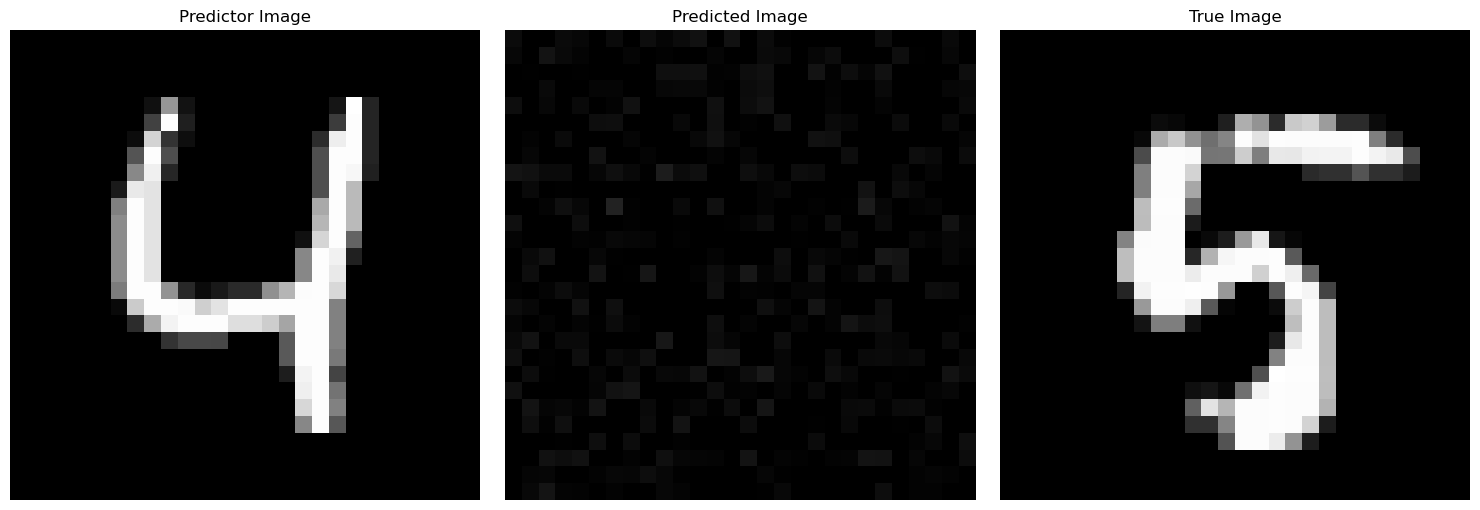

In [4]:
def plot_num2num_prediction(X, y, pred):
    """
    X, y, and pred are all numpy arrays of dimension (28, 28)
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(X.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[0].set_title(f"Predictor Image")
    axes[0].axis("off")
    axes[1].imshow(pred.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[1].set_title(f"Predicted Image")
    axes[1].axis("off")
    axes[2].imshow(y.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[2].set_title(f"True Image")
    axes[2].axis("off")
    plt.tight_layout()
    plt.show()

#select a random sample from our test dataset
rand_test_idx = np.random.randint(len(test_ds))
i = rand_test_idx

#index test Dataset to get predictor (X) and target (y)
X, y = test_ds[i]
X_gpu = torch.from_numpy(X).to(device) #put the data onto the gpu

#make a prediction without keeping track of the gradient
with torch.no_grad():
    pred = model(X_gpu)
    pred = pred.cpu().numpy()

#plot predictions
plot_num2num_prediction(X, y, pred)

In [5]:
def save_model_checkpoint(epoch, model, optimizer, loss):
    """
    Saves a model such that you can load it and resume training.
    :param epoch: int - the training epoch in which the model is being saved
    :param model: torch.nn.Module - your model you're training
    :param optimizer: torch.optim.Optimizer - the optimizer you're using to update nn params
    :param loss: object returned by your loss function (e.g. loss = loss_function(pred, y))
    """
    #save model for resuming training
    model_save_dir = os.path.join(os.getcwd(), "models", "MNIST_num2num", "model_checkpoints", "dense_nn_2HL")
    os.makedirs(model_save_dir, exist_ok = True)
    torch.save({
        "epoch" : epochs,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss
        }, os.path.join(model_save_dir, f"epoch{epoch}.pth"))

for epoch in range(epochs):
    print(f"Starting epoch {epoch + 1}")

    #Run training loop
    model.train()
    for batchnum, data in enumerate(train_dataloader):
        
        X, y = data
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_function(pred, y)

        #Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    #run eval loop
    evaluate_model(model, loss_function, test_dataloader)

    #save checkpoint
    save_model_checkpoint(epoch, model, optimizer, loss)

    #for loading, see https://pytorch.org/tutorials/beginner/saving_loading_models.html#load


Starting epoch 1
Avg test loss: 0.05509094810619141
Starting epoch 2
Avg test loss: 0.054823217133934884
Starting epoch 3
Avg test loss: 0.05459794093863652
Starting epoch 4
Avg test loss: 0.05465060049971453
Starting epoch 5
Avg test loss: 0.054532245646555205


In [6]:
#save the trained model for *inference*
model_save_dir = os.path.join(os.getcwd(), "models", "MNIST_num2num")
os.makedirs(model_save_dir, exist_ok = True)
torch.save(model.state_dict(), os.path.join(model_save_dir, "dense_nn_2HL.pth"))

#load it, because we can
model = DenseNeuralNetwork()
model.load_state_dict(torch.load(os.path.join(model_save_dir, "dense_nn_2HL.pth"), weights_only = True))
model.eval()
model.to(device)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)

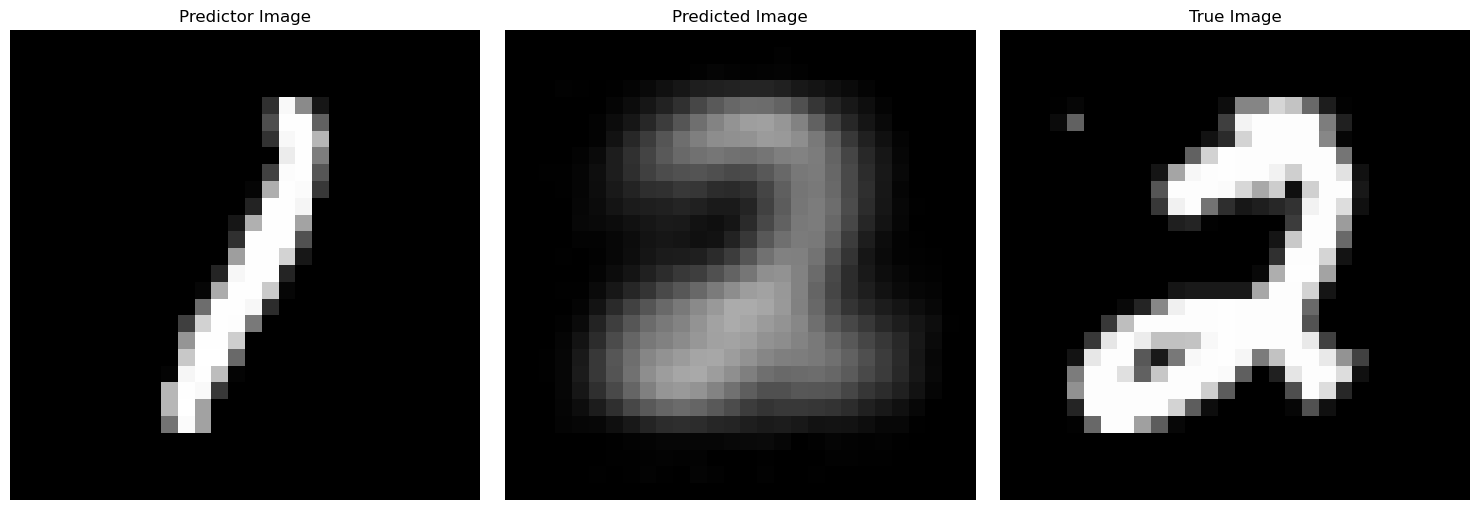

In [9]:
#make prediction plot as before, but with trained model
rand_test_idx = np.random.randint(len(test_ds))
i = rand_test_idx
X, y = test_ds[i]
X_gpu = torch.from_numpy(X).to(device)
with torch.no_grad():
    pred = model(X_gpu)
    pred = pred.cpu().numpy()
plot_num2num_prediction(X, y, pred)

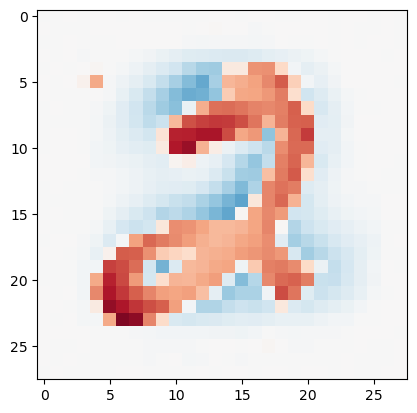

In [10]:
#plot the residual just for fun
plt.imshow(pred.squeeze() - y.squeeze(), cmap = "RdBu", vmin = -1., vmax = 1.)